In [1]:
#Import modules
import warnings
warnings.filterwarnings("ignore") 
import tensorflow
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from pathlib import Path

2024-07-14 20:32:10.149856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 20:32:10.150048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 20:32:10.332382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Image data generator 
train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

In [3]:
#Train Data
train_data = train_gen.flow_from_directory(
"/kaggle/input/faceshape-processed/dataset/train",
target_size = (48, 48),
batch_size = 64,
color_mode = "grayscale",
class_mode="categorical")

#Test Data
test_data = test_gen.flow_from_directory(
"/kaggle/input/faceshape-processed/dataset/test",
target_size = (48, 48),
batch_size = 64,
color_mode = "grayscale",
class_mode="categorical")

Found 3981 images belonging to 5 classes.
Found 998 images belonging to 5 classes.


In [4]:
#Get Validation Accuracy from logs
class ValAccEarlyStop(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ValAccEarlyStop, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [5]:

# Define a Sequential CNN model for image classification
cnn_model = Sequential([
    # First convolutional block
    Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu', input_shape=(48, 48, 1)),
    # Convolutional layer with 32 filters, 3x3 kernel, L2 regularization, 'same' padding, and ReLU activation
    Conv2D(filters=32, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    # Another convolutional layer with 32 filters, 3x3 kernel, L2 regularization, 'same' padding, and ReLU activation
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer to reduce spatial dimensions
    Dropout(0.25),  # Dropout layer to prevent overfitting

    # Second convolutional block
    Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'), 
    Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    Dropout(0.25), 
    
    # Third convolutional block
    Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, kernel_regularizer=l2(0.01), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    Dropout(0.25),  

    # Flatten the output from the convolutional layers to feed into fully connected layers
    Flatten(),

    # Fully connected layer with 512 units and ReLU activation
    Dense(512, activation='relu'),
    Dropout(0.25),  # Dropout layer to prevent overfitting

    # Output layer with 5 units (one for each class) and softmax activation for classification
    Dense(5, activation='softmax')
])

# Print the model summary
cnn_model.summary()

# Compile the model with Adam optimizer, categorical cross-entropy loss, and accuracy metric
cnn_model.compile(optimizer="adam", 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Calculate steps per epoch for training and validation
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

# Train the model using the training data, with early stopping based on validation accuracy
history = cnn_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=test_data,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[ValAccEarlyStop(0.79)]  # Custom callback to stop training if validation accuracy reaches 0.79
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,573 (5.04 MB)

 Trainable params: 1,321,573 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 583ms/step - accuracy: 0.1991 - loss: 11.6718 - val_accuracy: 0.2083 - val_loss: 3.9533
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2344 - loss: 3.9597 - val_accuracy: 0.3158 - val_loss: 3.9433
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - accuracy: 0.2123 - loss: 3.8628 - val_accuracy: 0.2250 - val_loss: 3.6387
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2656 - loss: 3.6367 - val_accuracy: 0.2105 - val_loss: 3.6300
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 440ms/step - accuracy: 0.2189 - loss: 3.5729 - val_accuracy: 0.2365 - val_loss: 3.4032
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2500 - loss: 3.4097 - val_accuracy: 0.2895 - val_loss: 3.3979
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 446ms/step - accuracy: 0.2452 - loss: 3.3501 - val_accuracy: 0.2375 - val_loss: 3.2068
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2812 - loss: 3.2245 - val_accuracy: 0.28

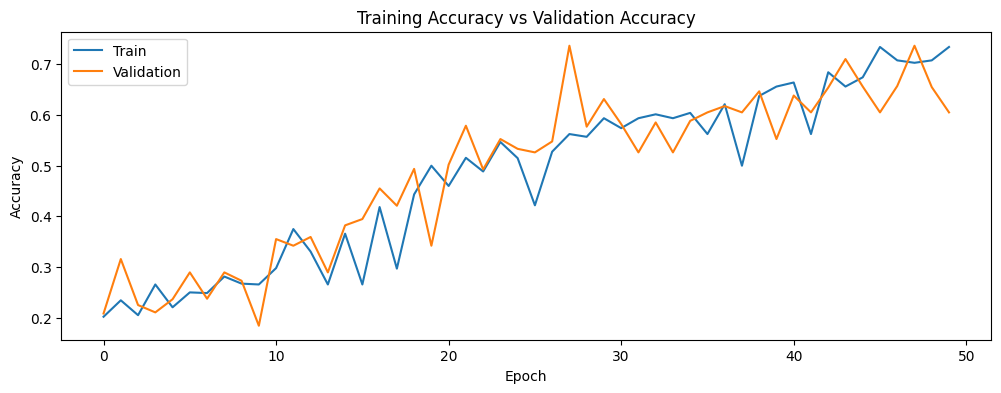

In [6]:
#For making the Accuracy Chart
fig , ax = plt.subplots(1, 1)
train_acc = history.history['accuracy']
fig.set_size_inches(12,4)

ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Training Accuracy vs Validation Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train','Validation'])

In [7]:
# Convert the model to JSON and save it to a file
model_structure = cnn_model.to_json()
path = Path("/kaggle/working/groveOn_model.json")
path.write_text(model_structure)

# Save the model
cnn_model.save('/kaggle/working/groveOn_model.h5')